# Class project

### 3. Anime face generation:
Given the image of anime faces as follows.
https://www.kaggle.com/splcher/animefacedataset
Use Variational Autoencoder and GAN to generate faces of anime characters.
Compare the performance of these two models.

> This is generative model using Variational Autoencoder that consists of encoder and decoder.

In [0]:
import os
!pip install -q kaggle

os.environ['KAGGLE_USERNAME'] = 'nuttrawitra' 
os.environ['KAGGLE_KEY'] = '' 
! kaggle datasets download -d splcher/animefacedataset

! unzip animefacedataset.zip

In [0]:
import numpy as np
import tensorflow as tf 
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model


In [0]:
WEIGHTS_FOLDER = './weights/'
if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

In [0]:
os.mkdir('anime')

> Using ImageDataGenerator, the Keras image preprocessing, to get anime data set directly from folder 'anime'. 

In [0]:
import shutil
shutil.move('images', 'anime')

INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 200 # Dimension of the latent vector (z)
NUM_IMAGES = 63565

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory('anime', 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

In [0]:
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, conv_strides, use_batch_norm = False, use_dropout = False):
  global K
  K.clear_session()
  
  n_layers = len(conv_filters)

  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
      if use_batch_norm:
        x = BathcNormalization()(x)
  
      x = LeakyReLU()(x)

      if use_dropout:
        x = Dropout(rate=0.25)(x)

  shape_before_flattening = K.int_shape(x)[1:] 
  x = Flatten()(x)  
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output, name = "vae_encoder")

In [8]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

vae_encoder.summary()

Model: "vae_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu_1[0][0]              
________________________________________________________________________________________

In [0]:
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  n_layers = len(conv_filters)
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output, name="vae_decoder")

In [10]:

vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = vae_shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
vae_decoder.summary()

Model: "vae_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        

In [0]:
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)
vae_model = Model(vae_input, vae_output, name='Variational Autoencoder Model')

vae_model.summary()

Model: "Variational Autoencoder Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu_1[0][0]              
______________________________________________________________________

In [0]:
LEARNING_RATE = 0.0005
N_EPOCHS = 200
LOSS_FACTOR = 10000

In [0]:
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

In [0]:
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

In [0]:
adam_optimizer = Adam(lr = LEARNING_RATE)
vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])
checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)

In [0]:
vae_model.fit_generator(data_flow, 
                        shuffle=True, 
                        epochs = N_EPOCHS, 
                        initial_epoch = 0, 
                        steps_per_epoch=NUM_IMAGES / BATCH_SIZE,
                        callbacks=[checkpoint_vae])

Epoch 1/200
125/124 [==============================] - 58s 464ms/step - loss: 650.1743 - r_loss: 0.0631 - kl_loss: 18.1754

Epoch 00001: saving model to ./weights/VAE/weights.h5
Epoch 2/200
125/124 [==============================] - 52s 418ms/step - loss: 442.0144 - r_loss: 0.0402 - kl_loss: 39.8707

Epoch 00002: saving model to ./weights/VAE/weights.h5
Epoch 3/200
125/124 [==============================] - 52s 415ms/step - loss: 386.3142 - r_loss: 0.0339 - kl_loss: 47.0176

Epoch 00003: saving model to ./weights/VAE/weights.h5
Epoch 4/200
125/124 [==============================] - 52s 418ms/step - loss: 353.8871 - r_loss: 0.0304 - kl_loss: 49.7327

Epoch 00004: saving model to ./weights/VAE/weights.h5
Epoch 5/200
125/124 [==============================] - 52s 419ms/step - loss: 340.2861 - r_loss: 0.0289 - kl_loss: 51.2993

Epoch 00005: saving model to ./weights/VAE/weights.h5
Epoch 6/200
125/124 [==============================] - 53s 420ms/step - loss: 332.4617 - r_loss: 0.0280 - kl_l

In [0]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:5]

In [0]:
def plot_compare_vae(images=None):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:5]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(30, 30))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)

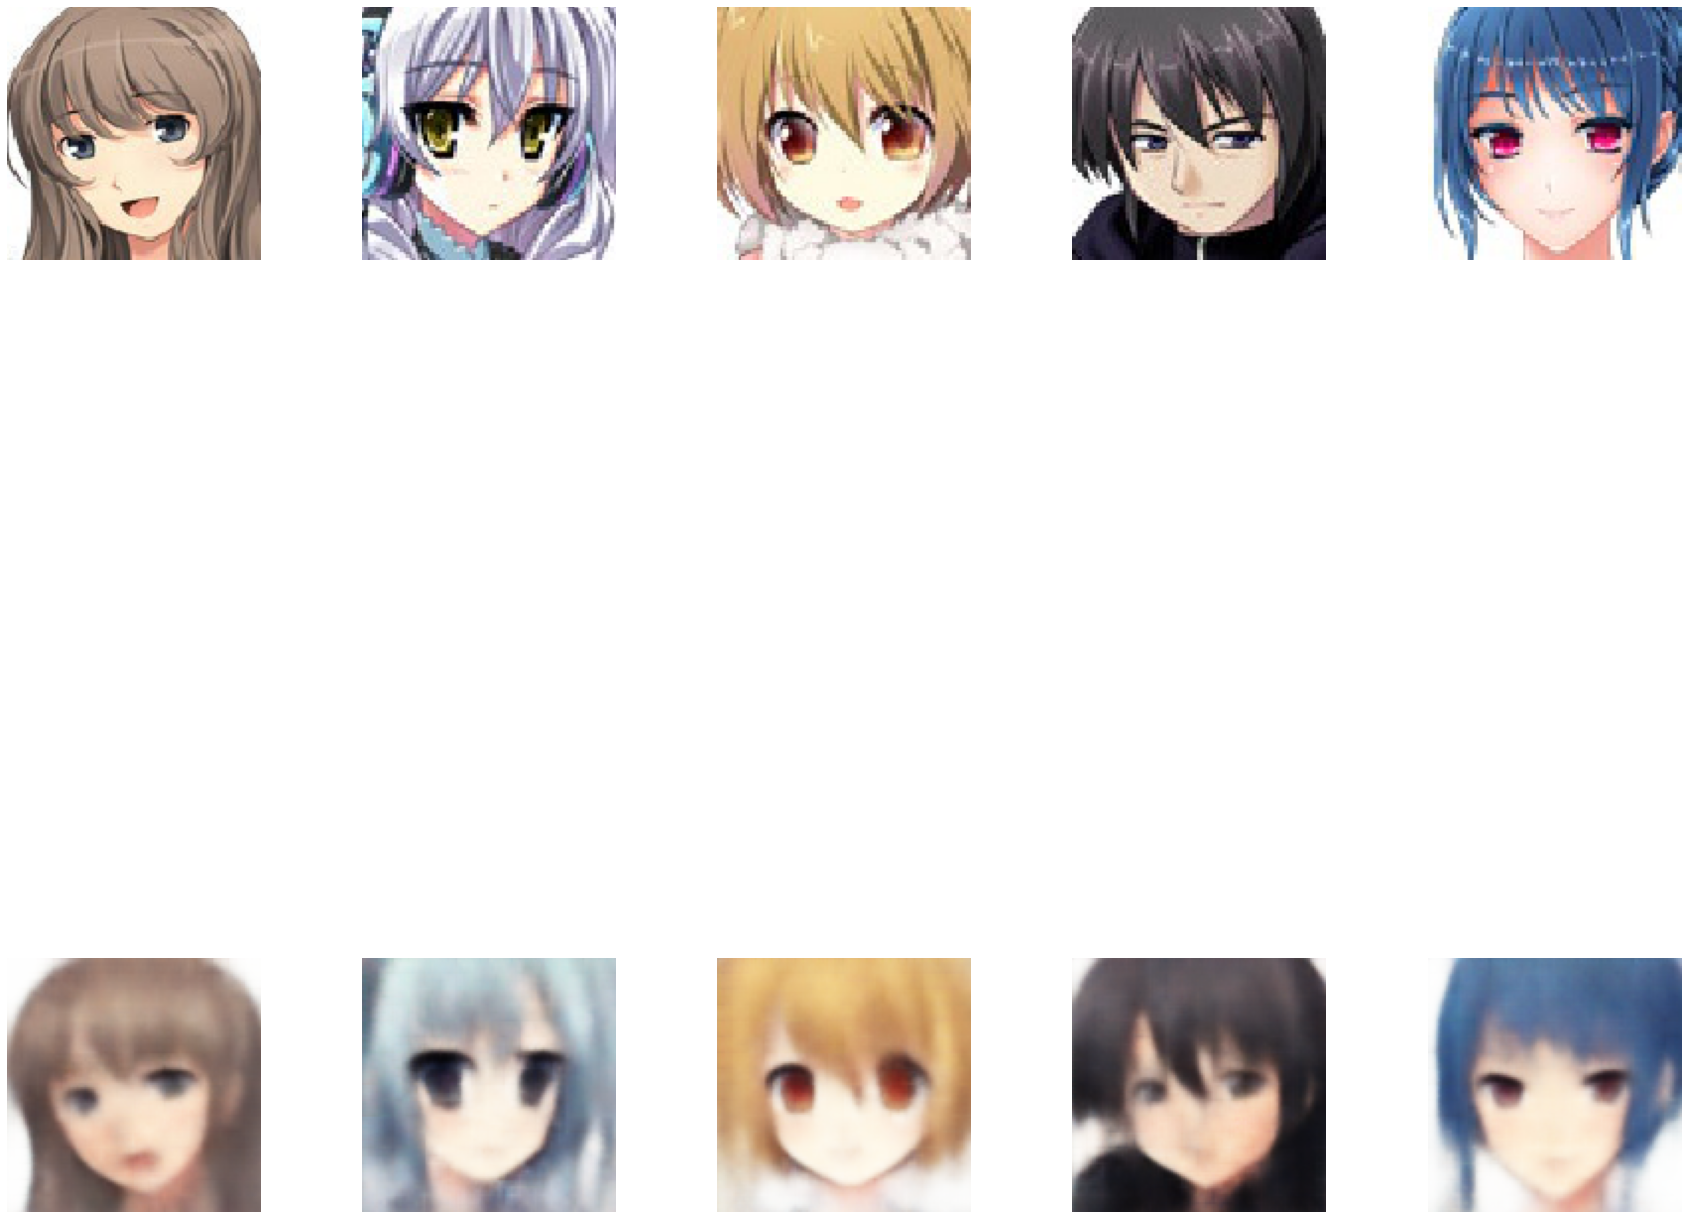

In [0]:
plot_compare_vae(images = example_images)

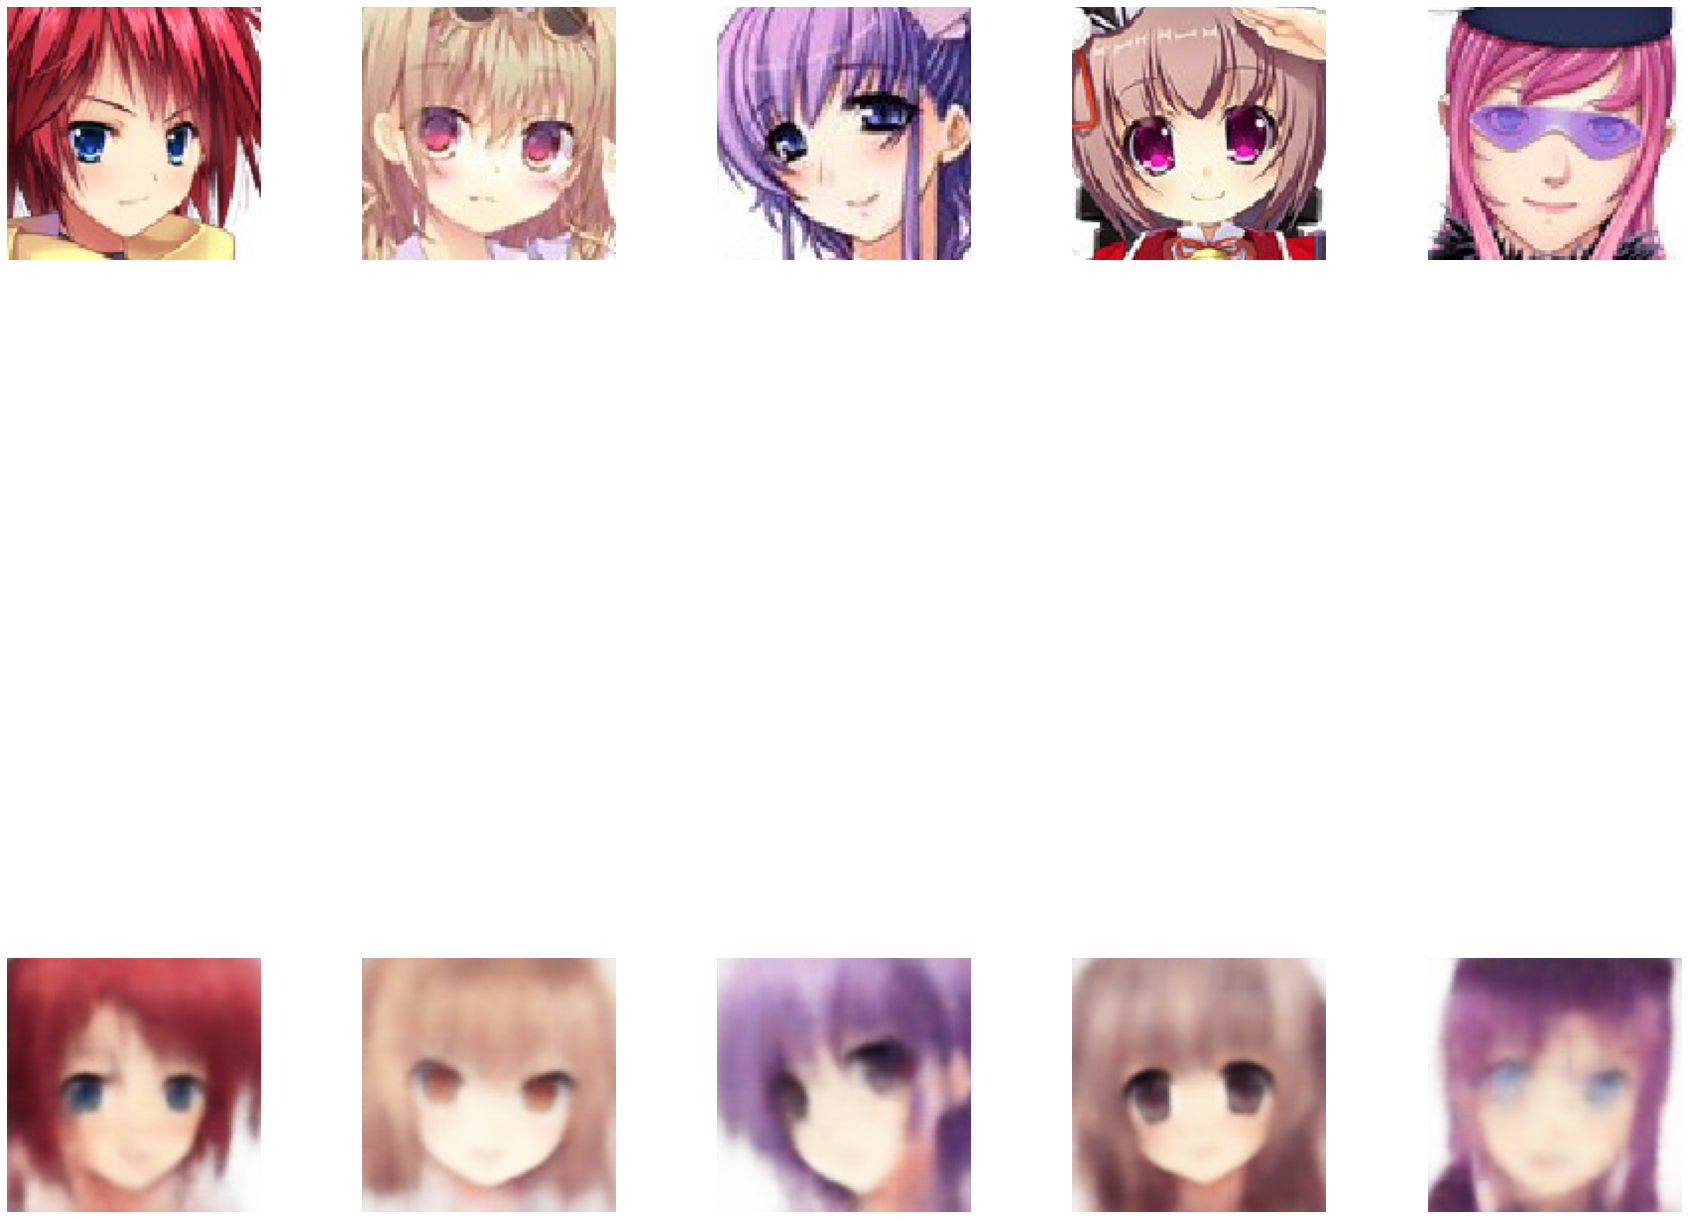

In [0]:
 plot_compare_vae()

In [0]:
def vae_generate_images(n_to_show):
  reconst_images = vae_decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(30, 30))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

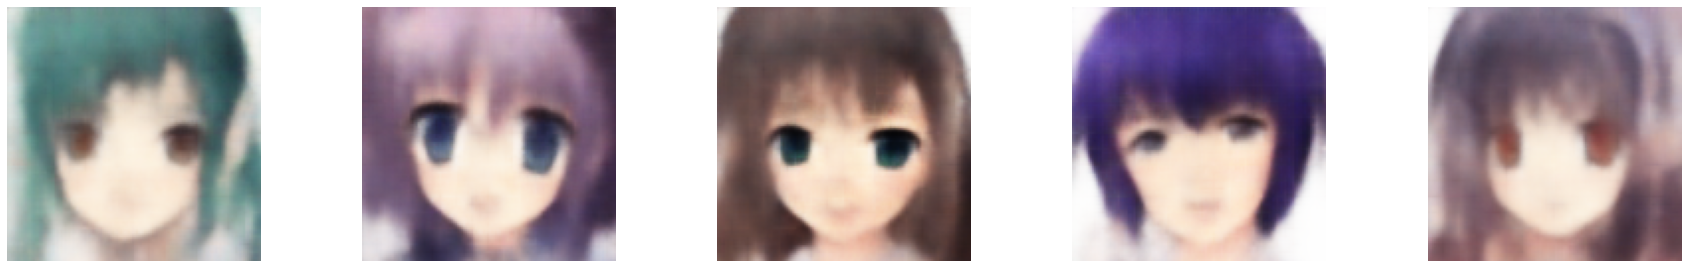

In [0]:
vae_generate_images(n_to_show=5)   

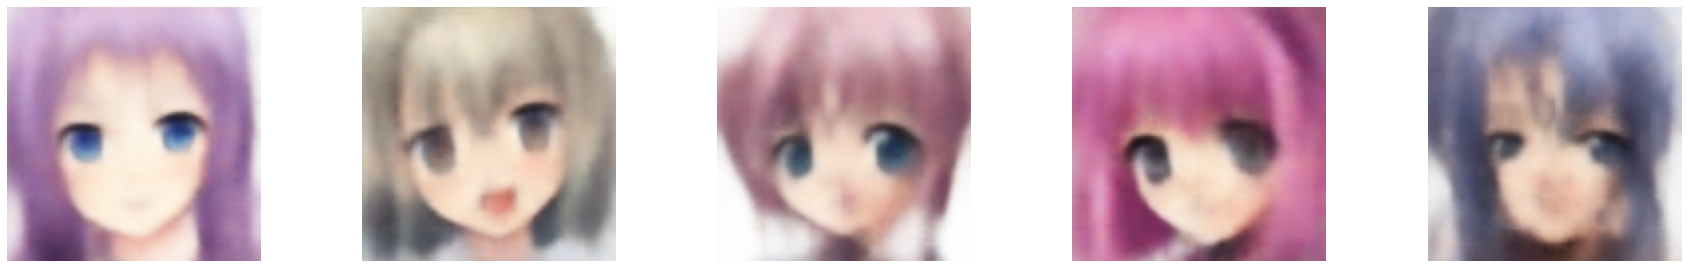

In [0]:
vae_generate_images(n_to_show=5)

In [0]:
from scipy.stats import norm

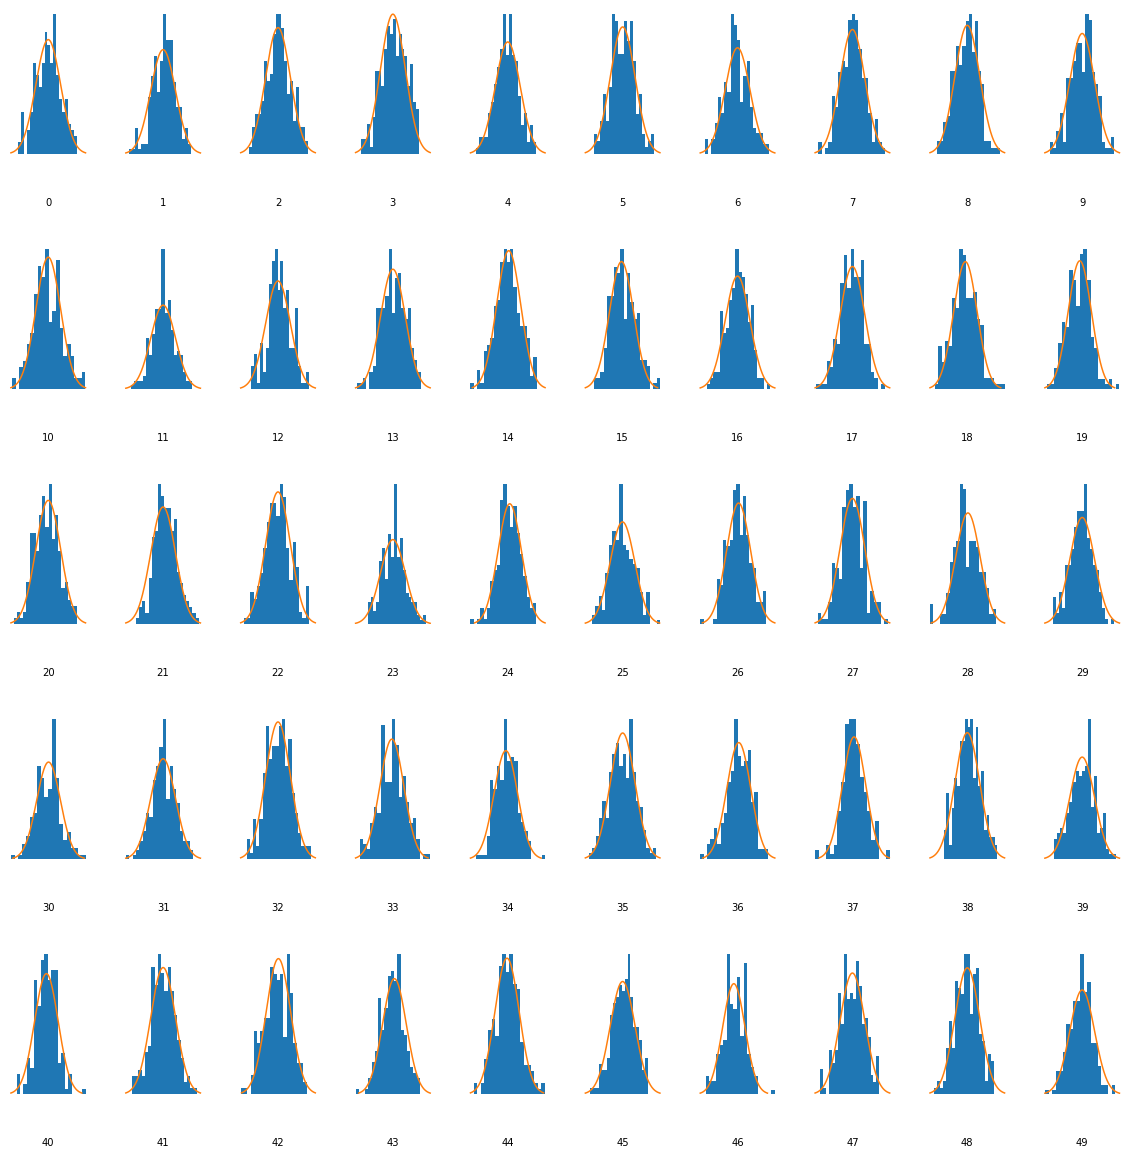

In [0]:

z_test = vae_encoder.predict(example_batch[:200])

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()